In [1]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
num_steps = 1000

In [6]:
from neural_ode import NeuralODE

In [7]:
def w_initializer(shape, scale=1):
    w = 2 * scale * (np.random.rand(*shape) - 0.5)    
    return w.astype('float32')


class PlanarFlow(tf.keras.Model):
    
    def __init__(self, dim, scale=1.0, bias_scale=1.0, w_scale=1.0, activation_fn=tf.nn.tanh):
        super().__init__()
        self.weight = tf.Variable(w_scale * (w_initializer([1, dim])), name='weight')
        self.bias = tf.Variable(scale * w_initializer([1, 1]), name='bias')
        self.scale = tf.Variable(bias_scale * (w_initializer([1, dim])), name='scale')
        self.activation = activation_fn
      
    def linear(self, z):
        return tf.reduce_sum(z * self.weight, axis=-1, keepdims=True) + self.bias    
        
    def call(self, inputs, **kwargs):
        z, logdet = inputs
                
        with tf.GradientTape() as g:
            g.watch(z)
            logits = self.linear(z)        
            hfunc = self.activation(logits)        
        
        new_z = self.scale * hfunc

        gradients = g.gradient(
            target=hfunc,
            sources=z,
        )
        new_logdet = - tf.matmul(gradients, tf.transpose(self.scale))        
        return new_z, logdet + new_logdet

    def compute_output_shape(self, input_shape):        
        return input_shape
    
    
class MultipleFlow(tf.keras.Model):
    
    def __init__(self, num_flows, flow_factory=lambda: PlanarFlow(2)):
        super().__init__()
        self.flows = [flow_factory() for _ in range(num_flows)]
        
    def call(self, inputs, **kwargs):
        z, logdet = inputs
        for flow in self.flows:
            z_k, logdet_k = flow(inputs)
            z = z + z_k
            logdet = logdet + logdet_k            
        return z, logdet

    def compute_output_shape(self, input_shape):        
        return input_shape

class AffineFlow(tf.keras.Model):
    
    def __init__(self, dim):
        super().__init__()
        self.weight = tf.Variable(np.array([[1, 0], [0, 1]]).astype("float32"), name='weight')
        self.bias = tf.Variable(np.zeros([1, dim]).astype("float32"), name='bias')                
      
    def linear(self, z):
        return tf.matmul(z, self.weight) + self.bias    
        
    def call(self, inputs, **kwargs):
        z, logdet = inputs
        new_z = self.linear(z)   
        new_logdet = - tf.expand_dims(tf.linalg.trace(self.weight), 0)        
        return new_z, logdet + new_logdet

    def compute_output_shape(self, input_shape):        
        return input_shape

In [170]:
flow = MultipleFlow(5)

In [213]:
from sklearn.datasets import make_moons
x_input = tf.to_float(make_moons(n_samples=256, noise=0.05)[0])
# x_input = tf.random_normal([512, 2])
# x_target = [[0.8, 0.2]]* x_input + [[-4, 5]]

In [214]:
neural_ode = NeuralODE(flow, tmax=1.0, num_steps=20)
x_output, x_logdet = neural_ode.forward([x_input, 0.0])

(-3.4674773580985163,
 2.3332058619867717,
 -2.4338843252147013,
 1.2867725721943846)

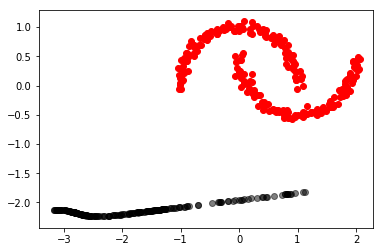

In [215]:
plt.scatter(*x_input.numpy().T, color='r')
# plt.scatter(*x_target.numpy().T, color='g')
plt.scatter(*x_output.numpy().T, color='k', alpha=0.5)
plt.axis("equal")

In [201]:
p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])

In [202]:
x_output, x_logdet = neural_ode.forward([x_input, 0.0])
# loss to maximize
neg_log_loss_per_sample = tf.reduce_sum(p0.log_prob(x_output), axis=1, keep_dims=True) - x_logdet
# loss to minimize
loss = - sum(neg_log_loss_per_sample)
loss, sum(x_logdet)

(<tf.Tensor: id=269588, shape=(1,), dtype=float32, numpy=array([40568.44], dtype=float32)>,
 <tf.Tensor: id=272149, shape=(1,), dtype=float32, numpy=array([38674.246], dtype=float32)>)

(-2.326946138691315,
 3.3366609805339666,
 -1.9279772602336296,
 2.515113290430773)

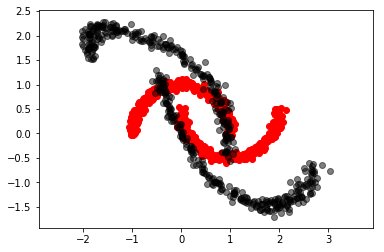

In [203]:
plt.scatter(*x_input.numpy().T, color='r')
plt.scatter(*x_output.numpy().T, color='k', alpha=0.5)
plt.axis("equal")

In [8]:
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1

def potential_energy(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0) - 2.)/.4)**2 \
        - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))

In [9]:
x_input = tf.random_normal([512, 2])

In [10]:
# flow = AffineFlow(2)
flow = MultipleFlow(1)
neural_ode = NeuralODE(flow, tmax=-1.0, num_steps=10)
odes = [NeuralODE(PlanarFlow(2, scale=0.1), tmax=1.0, num_steps=10) for i in range(8)]

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)

In [12]:
def compute_gradients_and_update(x_input):
    with tf.GradientTape() as g:
        inputs = [x_input, 0.0]
        weights = []
        for ode in odes:
            outputs = ode.forward(inputs)
            
            x_output, x_logdet = outputs
#             logp0 = tf.reduce_sum(p0.log_prob(x_output), axis=1, keepdims=True)
#             neg_log_loss_per_sample = logp0 - x_logdet
#             loss = - tf.reduce_sum(neg_log_loss_per_sample)
            loss = potential_energy(x_output) + x_logdet        
            loss = tf.reduce_mean(loss)
            weights.extend(ode._model.weights)
        
        gradients = g.gradient(
            target=loss,
            sources=weights,
        )        
        optimizer.apply_gradients(zip(gradients, weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

In [20]:
loss_history = []
for step in tqdm(range(1000)):
    loss = compute_gradients_and_update(x_input)
    loss_history.append(loss.numpy())

100%|██████████| 1000/1000 [00:07<00:00, 142.50it/s]


In [21]:
loss_history[-1:]

[1.5973417]

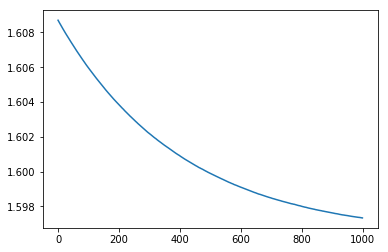

In [22]:
plt.plot(loss_history)

In [23]:
x_output, x_logdet = neural_ode.forward([x_input, 0.0])

(-0.7063558384402251,
 1.1134195014460537,
 -0.9268030854316209,
 1.3793484302611803)

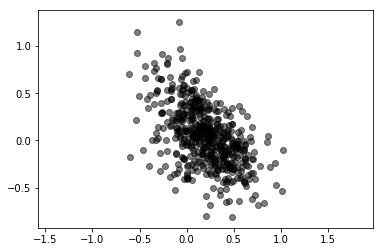

In [25]:
# plt.scatter(*x_input.numpy().T, color='r')
plt.scatter(*x_output.numpy().T, color='k', alpha=0.5)
plt.axis("equal")